In [27]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.eval_measures import meanabs, mse, rmse

In [2]:
df = pd.read_csv('Data/co2_mm_mlo.csv')
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [3]:
df['date'] = pd.to_datetime({'year': df.year, 'month': df.month, 'day': 1})
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [4]:
df.shape

(729, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
date            729 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.2 KB


In [7]:
df.set_index('date',inplace=True)

In [8]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [9]:
df.index.freq = 'MS'

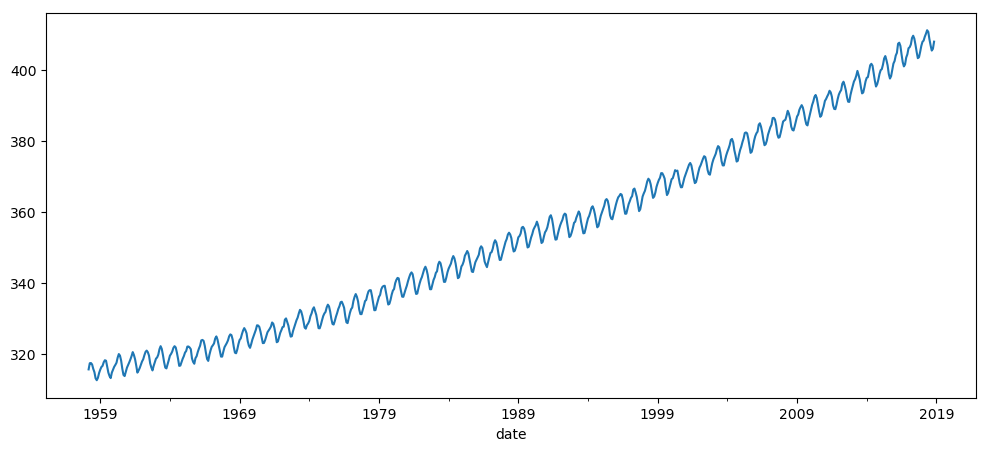

In [10]:
df['interpolated'].plot(figsize=(12,5));

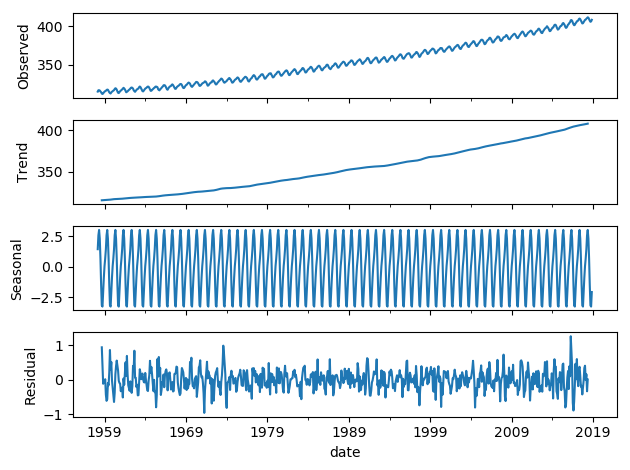

In [11]:
results = seasonal_decompose(df['interpolated'],model='additive')
results.plot();

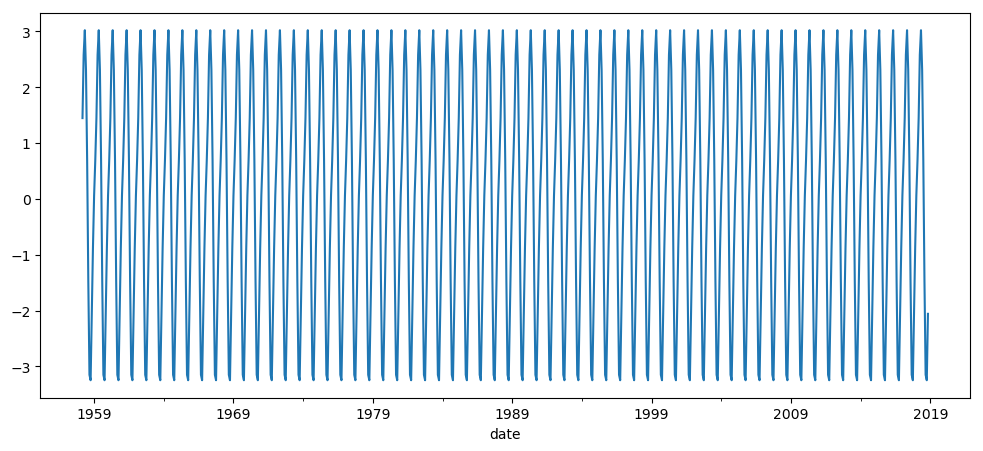

In [12]:
results.seasonal.plot(figsize=(12,5));

In [16]:
model = auto_arima(df['interpolated'],seasonal=True,m=12,suppress_warnings=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.462
Date:                            Fri, 20 Sep 2024   AIC                            424.925
Time:                                    22:16:35   BIC                            447.876
Sample:                                         0   HQIC                           433.781
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.044      0.296      -0.001       0.002
ma.L1         -0.3803      0.034    -11.130      0.000      -0.447      -0.313
ar.S.L12       0.9995      0.000   3054.231      0.000       0.999       1.000
ma.S.L12      -0.8631      0.022    -39.883      0.000      -0.906      -0.821
sigma2         0.0964      0.005     20.353      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       52.16   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.09   Prob(JB):                         0.16
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
len(df)

729

In [20]:
train = df[:705]
test = df[705:]

In [21]:
train.shape, test.shape

((705, 5), (24, 5))

In [22]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  705
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -204.241
Date:                            Fri, 20 Sep 2024   AIC                            416.482
Time:                                    22:18:53   BIC                            434.709
Sample:                                03-01-1958   HQIC                           423.526
                                     - 11-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3638      0.035    -10.532      0.000      -0.432      -0.296
ar.S.L12       0.9996      0.000   2616.657      0.000       0.999       1.000
ma.S.L12      -0.8585      0.024    -35.566      0.000      -0.906      -0.811
sigma2         0.0969      0.005     19.962      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       49.23   Jarque-Bera (JB):                 3.59
Prob(Q):                              0.15   Prob(JB):                         0.17
Heteroskedasticity (H):               1.16   Skew:                            -0.03
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
test_predictions = results.predict(start=len(train),end=len(train)+len(test)-1,typ='levels')
test_predictions

2016-12-01    404.842753
2017-01-01    405.962377
2017-02-01    406.779772
2017-03-01    407.710229
2017-04-01    409.239532
2017-05-01    409.837372
2017-06-01    409.053866
2017-07-01    407.367151
2017-08-01    405.246988
2017-09-01    403.848431
2017-10-01    404.128297
2017-11-01    405.676707
2017-12-01    407.156168
2018-01-01    408.275312
2018-02-01    409.092357
2018-03-01    410.022416
2018-04-01    411.551064
2018-05-01    412.148647
2018-06-01    411.365478
2018-07-01    409.679484
2018-08-01    407.560230
2018-09-01    406.162271
2018-10-01    406.442018
2018-11-01    407.989764
Freq: MS, dtype: float64

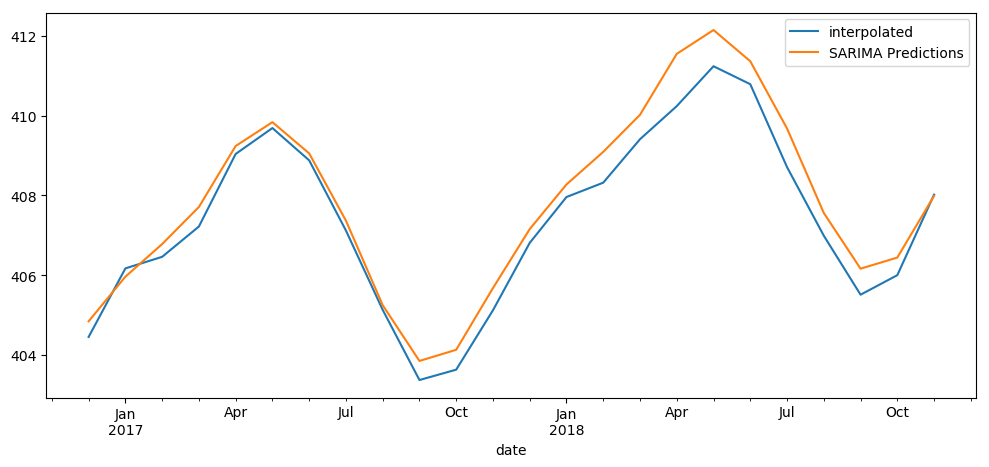

In [26]:
test['interpolated'].plot(figsize=(12,5),legend=True)
test_predictions.plot(legend=True,label='SARIMA Predictions');

In [29]:
print("MAE:", meanabs(test['interpolated'],test_predictions))
print("MSE:", mse(test['interpolated'],test_predictions))
print("RMSE:", rmse(test['interpolated'],test_predictions))

MAE: 0.47226676558092606
MSE: 0.31028957980113
RMSE: 0.5570364259194636


In [30]:
test['interpolated'].mean()

407.34499999999997

In [31]:
test_predictions.mean()

407.7974451972871

### Forecast into Unknown Future

In [32]:
model = SARIMAX(df['interpolated'],order=(0,1,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  729
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 12)   Log Likelihood                -247.652
Date:                            Fri, 20 Sep 2024   AIC                            501.303
Time:                                    22:25:06   BIC                            515.074
Sample:                                03-01-1958   HQIC                           506.617
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9997      0.000   3572.170      0.000       0.999       1.000
ma.S.L12      -0.9047      0.020    -45.578      0.000      -0.944      -0.866
sigma2         0.1077      0.005     20.000      0.000       0.097       0.118
===================================================================================
Ljung-Box (Q):                      111.77   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.18   Skew:                             0.11
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
forecast = results.predict(start=len(df),end=len(df)+len(test)-1,typ='levels').rename('SARIMA Forecast')
forecast

2018-12-01    409.468235
2019-01-01    410.646423
2019-02-01    411.366556
2019-03-01    412.283462
2019-04-01    413.701614
2019-05-01    414.328661
2019-06-01    413.621910
2019-07-01    411.932081
2019-08-01    409.879226
2019-09-01    408.415935
2019-10-01    408.671190
2019-11-01    410.213017
2019-12-01    411.660758
2020-01-01    412.838545
2020-02-01    413.558433
2020-03-01    414.475026
2020-04-01    415.892695
2020-05-01    416.519528
2020-06-01    415.813018
2020-07-01    414.123765
2020-08-01    412.071609
2020-09-01    410.608817
2020-10-01    410.863984
2020-11-01    412.405286
Freq: MS, Name: SARIMA Forecast, dtype: float64

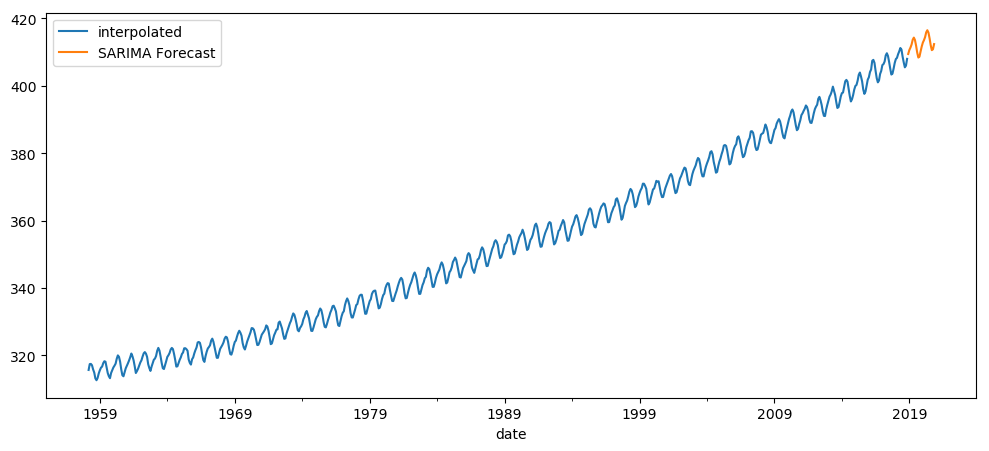

In [34]:
df['interpolated'].plot(figsize=(12,5),legend=True)
forecast.plot(legend=True);